<a href="https://colab.research.google.com/github/PedroTricossi/Covid-19-Nasa-Space-App-Analysis/blob/master/Covid_19_Nasa_Space_App_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**NASA Space Apps Covid-19**







  This notebook has been created to analyze data from São Paulo, Brazil, and feed our web application.
  
  This notebook might be seen a little different because there are no exploratory analyzes, and this is due to we already the data and the meaning we want to take.


### Libraries

In [0]:
!pip install geopandas

In [0]:
import os
import seaborn as sns
import numpy as np
import geopandas as gpd
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.svm import SVR
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from fbprophet import Prophet

pd.plotting.register_matplotlib_converters()
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Data Importation

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
covidDf = pd.read_csv('/content/drive/My Drive/DadosNasa/dados_covid_sp.csv')
covidDf.head(10)

,munic,casos,obitos,dia,mes,codigo_ibge,latitude,longitude
0,aruja,1.0,NaN,26,3,3503901.0,-23.3965,-46.3200
1,barueri,3.0,NaN,26,3,3505708.0,-23.5057,-46.8790
2,caieiras,2.0,NaN,26,3,3509007.0,-23.3607,-46.7397
3,campinas,4.0,NaN,26,3,3509502.0,-22.9053,-47.0659
4,carapicuiba,2.0,NaN,26,3,3510609.0,-23.5235,-46.8407
5,cotia,5.0,NaN,26,3,3513009.0,-23.6022,-46.9190
6,embu das artes,1.0,NaN,26,3,3515004.0,-23.6437,-46.8579
7,guarulhos,9.0,1.0,26,3,3518800.0,-23.4538,-46.5333
8,hortolandia,1.0,NaN,26,3,3519071.0,-22.8529,-47.2143
9,iracemapolis,1.0,NaN,26,3,3521408.0,-22.5832,-47.5230


In [0]:
#GPD is a pandas library to use geographic data

covidGeo = gpd.read_file("/content/drive/My Drive/DadosNasa/35MUE250GC_SIR.shp")

In [0]:
covidGeo.head(200)

,NM_MUNICIP,CD_GEOCMU,geometry
0,GUAIÇARA,3517208,"POLYGON ((-49.82514 -21.58632, -49.82509 -21.5..."
1,AURIFLAMA,3504206,"POLYGON ((-50.61899 -20.66481, -50.61869 -20.6..."
2,IPAUSSU,3520905,"POLYGON ((-49.67444 -23.05396, -49.67364 -23.0..."
3,HORTOLÂNDIA,3519071,"POLYGON ((-47.24001 -22.84656, -47.24036 -22.8..."
4,BARRA DO TURVO,3505401,"POLYGON ((-48.50267 -24.74675, -48.50245 -24.7..."
...,...,...,...
195,SÃO JOAQUIM DA BARRA,3549409,"POLYGON ((-47.99916 -20.61157, -47.99987 -20.6..."
196,PLATINA,3539707,"POLYGON ((-50.25568 -22.55681, -50.25549 -22.5..."
197,JUQUIÁ,3526100,"POLYGON ((-47.77586 -24.29819, -47.77551 -24.2..."
198,OLÍMPIA,3533908,"POLYGON ((-49.06535 -20.81194, -49.06556 -20.8..."


### Data cleaning

In [0]:
#Transforming Date in a readible column

covidDf['dateInt']="2020" + covidDf['mes'].astype(str).str.zfill(2)+ covidDf['dia'].astype(str).str.zfill(2)
covidDf['Date'] = pd.to_datetime(covidDf['dateInt'], format='%Y%m%d')
covidDf.codigo_ibge = covidDf.codigo_ibge.astype(str)
covidDf['codigo_ibge'] = covidDf['codigo_ibge'].str[:7]

In [0]:
covidDf.head()

,munic,casos,obitos,dia,mes,codigo_ibge,latitude,longitude,dateInt,Date
0,aruja,1.0,NaN,26,3,3503901,-23.3965,-46.3200,20200326,2020-03-26
1,barueri,3.0,NaN,26,3,3505708,-23.5057,-46.8790,20200326,2020-03-26
2,caieiras,2.0,NaN,26,3,3509007,-23.3607,-46.7397,20200326,2020-03-26
3,campinas,4.0,NaN,26,3,3509502,-22.9053,-47.0659,20200326,2020-03-26
4,carapicuiba,2.0,NaN,26,3,3510609,-23.5235,-46.8407,20200326,2020-03-26


In [0]:
#Merging the COVID data with the geographical data

df = pd.merge (covidDf, covidGeo, how = 'left', left_on = ['codigo_ibge'], right_on = ['CD_GEOCMU'])

In [0]:
df.head(10)

,munic,casos,obitos,dia,mes,codigo_ibge,latitude,longitude,dateInt,Date,NM_MUNICIP,CD_GEOCMU,geometry
0,aruja,1.0,NaN,26,3,3503901,-23.3965,-46.3200,20200326,2020-03-26,ARUJÁ,3503901,"POLYGON ((-46.36995 -23.37809, -46.37010 -23.3..."
1,barueri,3.0,NaN,26,3,3505708,-23.5057,-46.8790,20200326,2020-03-26,BARUERI,3505708,"POLYGON ((-46.89620 -23.48601, -46.89622 -23.4..."
2,caieiras,2.0,NaN,26,3,3509007,-23.3607,-46.7397,20200326,2020-03-26,CAIEIRAS,3509007,"POLYGON ((-46.76180 -23.33293, -46.76104 -23.3..."
3,campinas,4.0,NaN,26,3,3509502,-22.9053,-47.0659,20200326,2020-03-26,CAMPINAS,3509502,"POLYGON ((-47.07157 -22.73097, -47.07123 -22.7..."
4,carapicuiba,2.0,NaN,26,3,3510609,-23.5235,-46.8407,20200326,2020-03-26,CARAPICUÍBA,3510609,"POLYGON ((-46.86204 -23.53778, -46.86212 -23.5..."
5,cotia,5.0,NaN,26,3,3513009,-23.6022,-46.9190,20200326,2020-03-26,COTIA,3513009,"POLYGON ((-46.96234 -23.60249, -46.96206 -23.6..."
6,embu das artes,1.0,NaN,26,3,3515004,-23.6437,-46.8579,20200326,2020-03-26,EMBU DAS ARTES,3515004,"POLYGON ((-46.91826 -23.65788, -46.91832 -23.6..."
7,guarulhos,9.0,1.0,26,3,3518800,-23.4538,-46.5333,20200326,2020-03-26,GUARULHOS,3518800,"POLYGON ((-46.48206 -23.36072, -46.48206 -23.3..."
8,hortolandia,1.0,NaN,26,3,3519071,-22.8529,-47.2143,20200326,2020-03-26,HORTOLÂNDIA,3519071,"POLYGON ((-47.24001 -22.84656, -47.24036 -22.8..."
9,iracemapolis,1.0,NaN,26,3,3521408,-22.5832,-47.5230,20200326,2020-03-26,IRACEMÁPOLIS,3521408,"POLYGON ((-47.56360 -22.57489, -47.56365 -22.5..."


In [0]:
#Taking off unnecessary columns

df = df.drop(columns=['codigo_ibge', 'dia', 'mes', 'dateInt'] )
df.head()

,munic,casos,obitos,latitude,longitude,Date,NM_MUNICIP,CD_GEOCMU,geometry
0,aruja,1.0,NaN,-23.3965,-46.3200,2020-03-26,ARUJÁ,3503901,"POLYGON ((-46.36995 -23.37809, -46.37010 -23.3..."
1,barueri,3.0,NaN,-23.5057,-46.8790,2020-03-26,BARUERI,3505708,"POLYGON ((-46.89620 -23.48601, -46.89622 -23.4..."
2,caieiras,2.0,NaN,-23.3607,-46.7397,2020-03-26,CAIEIRAS,3509007,"POLYGON ((-46.76180 -23.33293, -46.76104 -23.3..."
3,campinas,4.0,NaN,-22.9053,-47.0659,2020-03-26,CAMPINAS,3509502,"POLYGON ((-47.07157 -22.73097, -47.07123 -22.7..."
4,carapicuiba,2.0,NaN,-23.5235,-46.8407,2020-03-26,CARAPICUÍBA,3510609,"POLYGON ((-46.86204 -23.53778, -46.86212 -23.5..."


In [0]:
#Changing the variable names

df.rename(columns={'NM_MUNICIP':'City','casos':'Confirmed','obitos':'Deaths','latitude':'Lat','longitude':'Long','geometry':'Geometry','Quantidade_existente':'Beds'}, inplace=True)
df.head()

,munic,Confirmed,Deaths,Lat,Long,Date,City,CD_GEOCMU,Geometry
0,aruja,1.0,NaN,-23.3965,-46.3200,2020-03-26,ARUJÁ,3503901,"POLYGON ((-46.36995 -23.37809, -46.37010 -23.3..."
1,barueri,3.0,NaN,-23.5057,-46.8790,2020-03-26,BARUERI,3505708,"POLYGON ((-46.89620 -23.48601, -46.89622 -23.4..."
2,caieiras,2.0,NaN,-23.3607,-46.7397,2020-03-26,CAIEIRAS,3509007,"POLYGON ((-46.76180 -23.33293, -46.76104 -23.3..."
3,campinas,4.0,NaN,-22.9053,-47.0659,2020-03-26,CAMPINAS,3509502,"POLYGON ((-47.07157 -22.73097, -47.07123 -22.7..."
4,carapicuiba,2.0,NaN,-23.5235,-46.8407,2020-03-26,CARAPICUÍBA,3510609,"POLYGON ((-46.86204 -23.53778, -46.86212 -23.5..."


### Data Analysis

In [0]:
#Grouping data by its date

datewise=df.groupby(["Date"]).agg({"Confirmed":'sum',"Deaths":'sum'})

In [0]:
print("Basic Information")
print("Total number of cities in São Paulo with Disease Spread: ",len(df["munic"].unique()))
print("Total number of Confirmed Cases in São Paulo: ",datewise["Confirmed"].iloc[-1])
print("Total number of Deaths Cases in São Paulo: ",datewise["Deaths"].iloc[-1])

Basic Information
Total number of cities in São Paulo with Disease Spread:  439
Total number of Confirmed Cases in São Paulo:  51097.0
Total number of Deaths Cases in São Paulo:  4118.0


<function matplotlib.pyplot.xlabel>

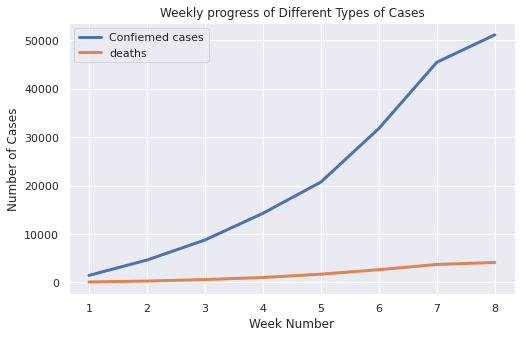

In [0]:
datewise["WeekOfYear"]=datewise.index.weekofyear

week_num=[]
weekwise_confirmed=[]
weekwise_deaths=[]
w=1

for i in list(datewise["WeekOfYear"].unique()):
    weekwise_confirmed.append(datewise[datewise["WeekOfYear"]==i]["Confirmed"].iloc[-1])
    weekwise_deaths.append(datewise[datewise["WeekOfYear"]==i]["Deaths"].iloc[-1])
    week_num.append(w)
    w=w+1

sns.set()
plt.figure(figsize=(8,5))
plt.grid(True)
plt.plot(week_num,weekwise_confirmed,linewidth=3)
plt.plot(week_num,weekwise_deaths,linewidth=3)
plt.legend(['Confiemed cases', 'deaths'])
plt.ylabel("Number of Cases")
plt.xlabel("Week Number")
plt.title("Weekly progress of Different Types of Cases")
plt.xlabel

Text(0.5, 1.0, 'Weekly increase in Number of Death Cases')

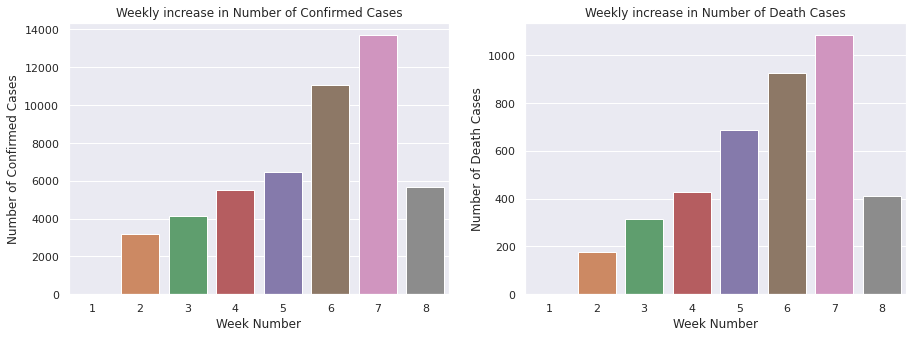

In [0]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5))
sns.barplot(x=week_num,y=pd.Series(weekwise_confirmed).diff().fillna(0),ax=ax1)
sns.barplot(x=week_num,y=pd.Series(weekwise_deaths).diff().fillna(0),ax=ax2)
ax1.set_xlabel("Week Number")
ax2.set_xlabel("Week Number")
ax1.set_ylabel("Number of Confirmed Cases")
ax2.set_ylabel("Number of Death Cases")
ax1.set_title("Weekly increase in Number of Confirmed Cases")
ax2.set_title("Weekly increase in Number of Death Cases")

In [0]:
citywise=df[df["Date"]==df["Date"].max()].groupby(["munic"]).agg({"Confirmed":'sum',"Deaths":'sum'}).sort_values(["Confirmed"],ascending=False)
citywise["Mortality"]=(citywise["Deaths"]/citywise["Confirmed"])*100

Text(0, 0.5, 'Cities')

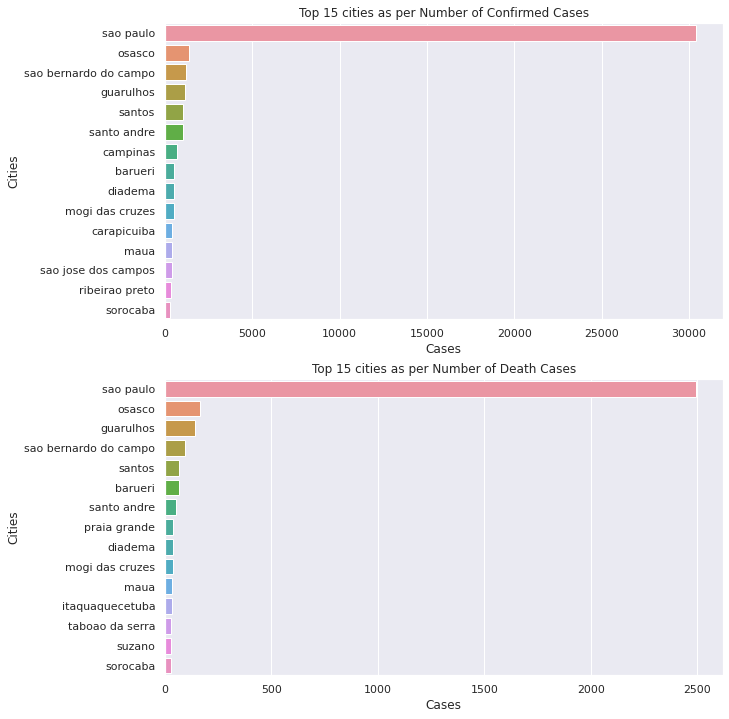

In [0]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,12))
top_15_confirmed=citywise.sort_values(["Confirmed"],ascending=False).head(15)
top_15_deaths=citywise.sort_values(["Deaths"],ascending=False).head(15)
sns.barplot(x=top_15_confirmed["Confirmed"],y=top_15_confirmed.index,ax=ax1)
ax1.set_title("Top 15 cities as per Number of Confirmed Cases")
ax1.set_xlabel("Cases")
ax1.set_ylabel("Cities")
sns.barplot(x=top_15_deaths["Deaths"],y=top_15_deaths.index,ax=ax2)
ax2.set_title("Top 15 cities as per Number of Death Cases")
ax2.set_xlabel("Cases")
ax2.set_ylabel("Cities")

In [0]:
datewise["Mortality Rate"]=(datewise["Deaths"]/datewise["Confirmed"])*100

print("Average Mortality Rate",datewise["Mortality Rate"].mean())
print("Median Mortality Rate",datewise["Mortality Rate"].median())

Average Mortality Rate 7.287384012188112
Median Mortality Rate 7.30032062809274


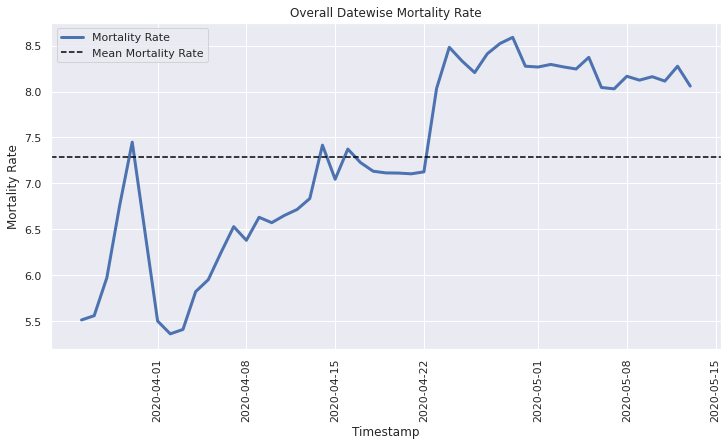

In [0]:
fig, (ax1) = plt.subplots(1,figsize=(12,6))
ax1.plot(datewise["Mortality Rate"],label='Mortality Rate',linewidth=3)
ax1.axhline(datewise["Mortality Rate"].mean(),linestyle='--',color='black',label="Mean Mortality Rate")
ax1.set_ylabel("Mortality Rate")
ax1.set_xlabel("Timestamp")
ax1.set_title("Overall Datewise Mortality Rate")
ax1.legend()
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)  

Text(0, 0.5, 'Cities')

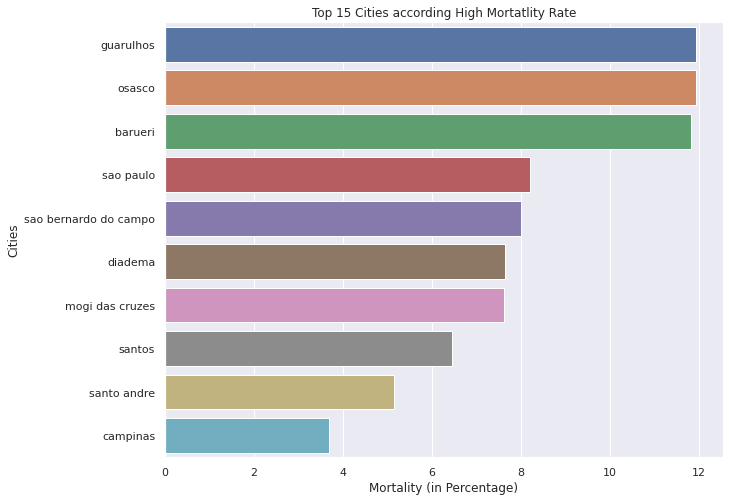

In [0]:
fig, (ax1) = plt.subplots(1,figsize=(10,8))
citywise_plot_mortal=citywise[citywise["Confirmed"]>500].sort_values(["Mortality"],ascending=False).head(15)
sns.barplot(x=citywise_plot_mortal["Mortality"],y=citywise_plot_mortal.index,ax=ax1)
ax1.set_title("Top 15 Cities according High Mortatlity Rate")
ax1.set_xlabel("Mortality (in Percentage)")
ax1.set_ylabel("Cities")

### Using machine Learning into data

In [0]:
#standarding data

std = StandardScaler()
X=citywise[["Confirmed","Deaths"]]
X=std.fit_transform(X)

In [0]:
#Clustering Data

wcss=[]
sil=[]
for i in range(2,11):
    clf=KMeans(n_clusters=i,init='k-means++',random_state=42)
    clf.fit(X)
    labels=clf.labels_
    centroids=clf.cluster_centers_
    sil.append(silhouette_score(X, labels, metric='euclidean'))
    wcss.append(clf.inertia_)

Text(0.5, 1.0, 'Silhouette Score Method')

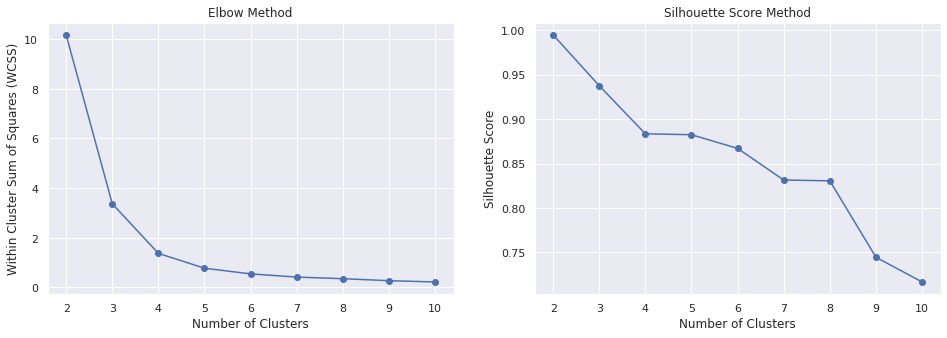

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,5))
x=np.arange(2,11)
ax1.plot(x,wcss,marker='o')
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Within Cluster Sum of Squares (WCSS)")
ax1.set_title("Elbow Method")
x=np.arange(2,11)
ax2.plot(x,sil,marker='o')
ax2.set_xlabel("Number of Clusters")
ax2.set_ylabel("Silhouette Score")
ax2.set_title("Silhouette Score Method")

In [0]:
clf_final=KMeans(n_clusters=4,init='k-means++',random_state=42)
clf_final.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [0]:
citywise["Clusters"]=clf_final.predict(X)

In [0]:
cluster_summary=pd.concat([citywise[citywise["Clusters"]==1].head(6),citywise[citywise["Clusters"]==2].head(6),citywise[citywise["Clusters"]==3].head(6),citywise[citywise["Clusters"]==4].head(6),citywise[citywise["Clusters"]==0].head(6)])
cluster_summary.style.background_gradient(cmap='Reds')

,Confirmed,Deaths,Mortality,Clusters
munic,,,,
sao paulo,30402.000000,2494.000000,8.203408,1
osasco,1390.000000,166.000000,11.942446,2
sao bernardo do campo,1210.000000,97.000000,8.016529,2
guarulhos,1189.000000,142.000000,11.942809,2
santos,1069.000000,69.000000,6.454630,2
santo andre,1048.000000,54.000000,5.152672,2
campinas,730.000000,27.000000,3.698630,3
barueri,558.000000,66.000000,11.827957,3
diadema,523.000000,40.000000,7.648184,3


In [0]:
datewise["Days Since"]=datewise.index-datewise.index[0]
datewise["Days Since"]=datewise["Days Since"].dt.days

In [0]:
#Creating a table to keep the RMSE

train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
model_scores=[]

In [0]:
#Appling a linear regression into data

lin_reg=LinearRegression(normalize=True)
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))

In [0]:
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Error for Linear Regression:  8879.969145483201


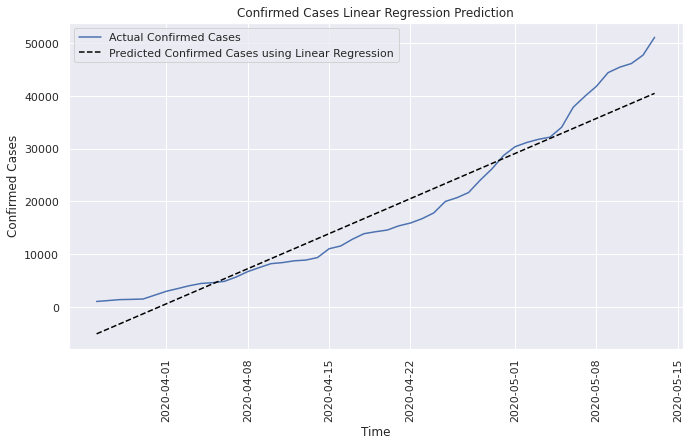

In [0]:
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(datewise["Days Since"]).reshape(-1,1))
plt.plot(datewise["Confirmed"],label="Actual Confirmed Cases")
plt.plot(datewise.index,prediction_linreg, linestyle='--',label="Predicted Confirmed Cases using Linear Regression",color='black')
plt.xlabel('Time')
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Linear Regression Prediction")
plt.xticks(rotation=90)
plt.legend()

In [0]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]

In [0]:
#Applying polinomial regression into data.

poly = PolynomialFeatures(degree = 4) 
train_poly=poly.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1))
y=train_ml["Confirmed"]
linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)
prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_poly))
model_scores.append(rmse_poly)

In [0]:
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

Root Mean Squared Error for Polynomial Regression:  2707.764994933423


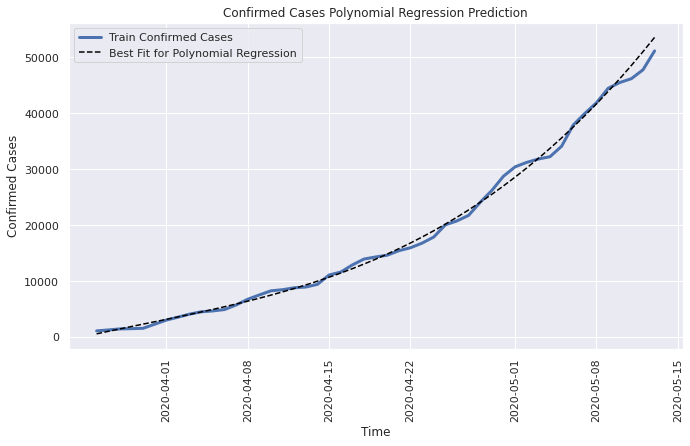

In [0]:
comp_data=poly.fit_transform(np.array(datewise["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)
plt.plot(datewise["Confirmed"],label="Train Confirmed Cases",linewidth=3)
plt.plot(datewise.index,predictions_poly, linestyle='--',label="Best Fit for Polynomial Regression",color='black')
plt.xlabel('Time')
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Polynomial Regression Prediction")
plt.xticks(rotation=90)
plt.legend()

In [0]:
new_prediction_poly=[]
for i in range(1,18):
    new_date_poly=poly.fit_transform(np.array(datewise["Days Since"].max()+i).reshape(-1,1))
    new_prediction_poly.append(linreg.predict(new_date_poly)[0])

In [0]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]

In [0]:
#Applying a SVM(Support vector machine)

svm=SVR(C=1,degree=5,kernel='poly',epsilon=0.01)

svm.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

prediction_valid_svm=svm.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [0]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))
print("Root Mean Square Error for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))

Root Mean Square Error for Support Vectore Machine:  17934.34272746871


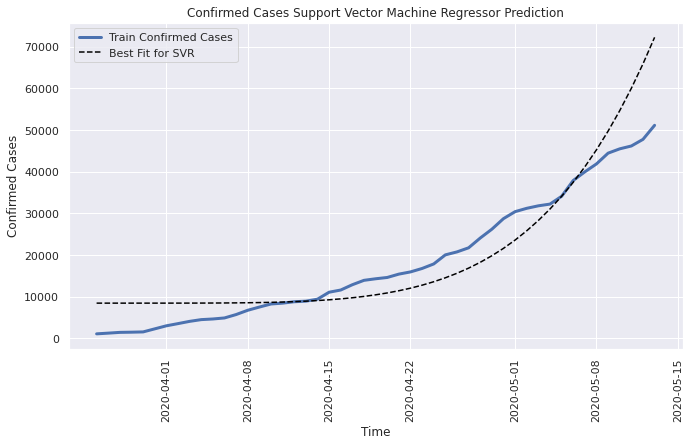

In [0]:
plt.figure(figsize=(11,6))
prediction_svm=svm.predict(np.array(datewise["Days Since"]).reshape(-1,1))
plt.plot(datewise["Confirmed"],label="Train Confirmed Cases",linewidth=3)
plt.plot(datewise.index,prediction_svm, linestyle='--',label="Best Fit for SVR",color='black')
plt.xlabel('Time')
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Support Vector Machine Regressor Prediction")
plt.xticks(rotation=90)
plt.legend()

In [0]:
new_date=[]
new_prediction_lr=[]
new_prediction_svm=[]
for i in range(1,18):
    new_date.append(datewise.index[-1]+timedelta(days=i))
    new_prediction_lr.append(lin_reg.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0][0])
    new_prediction_svm.append(svm.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0])

In [0]:
#Algorithm score comparison

pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_lr,new_prediction_poly,new_prediction_svm),
                               columns=["Dates","Linear Regression Prediction","Polynonmial Regression Prediction","SVM Prediction"])
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction
0,2020-05-14,41433.180470,56177.845113,79126.277274
1,2020-05-15,42382.486957,58929.945042,86641.544285
2,2020-05-16,43331.793443,61780.777296,94782.692428
3,2020-05-17,44281.099929,64732.147412,103588.025478
4,2020-05-18,45230.406415,67785.845605,113097.379062


### Time series Machine Learning

In [0]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]

In [0]:
#Applying a hold linear regression

holt=Holt(np.asarray(model_train["Confirmed"])).fit(smoothing_level=0.2, smoothing_slope=0.1,optimized=False)
y_pred=valid.copy()

y_pred["Holt"]=holt.forecast(len(valid))
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"])))

Root Mean Square Error Holt's Linear Model:  1995.2653941626766


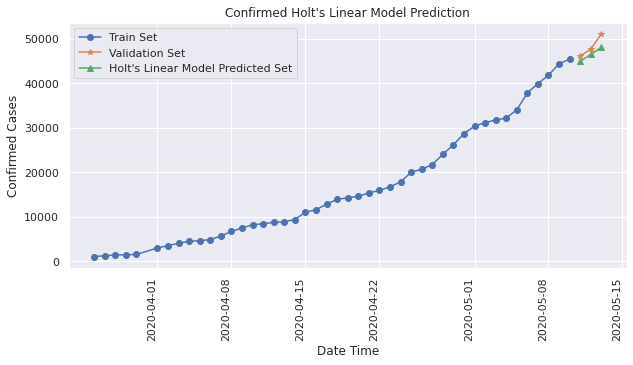

In [0]:
plt.figure(figsize=(10,5))
plt.plot(model_train.Confirmed,label="Train Set",marker='o')
valid.Confirmed.plot(label="Validation Set",marker='*')
y_pred.Holt.plot(label="Holt's Linear Model Predicted Set",marker='^')
plt.ylabel("Confirmed Cases")
plt.xlabel("Date Time")
plt.title("Confirmed Holt's Linear Model Prediction")
plt.xticks(rotation=90)
plt.legend()

In [0]:
holt_new_date=[]
holt_new_prediction=[]
for i in range(1,18):
    holt_new_date.append(datewise.index[-1]+timedelta(days=i))
    holt_new_prediction.append(holt.forecast((len(valid)+i))[-1])

model_predictions["Holt's Linear Model Prediction"]=holt_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction
0,2020-05-14,41433.180470,56177.845113,79126.277274,49664.631754
1,2020-05-15,42382.486957,58929.945042,86641.544285,51241.249647
2,2020-05-16,43331.793443,61780.777296,94782.692428,52817.867541
3,2020-05-17,44281.099929,64732.147412,103588.025478,54394.485434
4,2020-05-18,45230.406415,67785.845605,113097.379062,55971.103327


In [0]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]

In [0]:
#Applying a Hold Winter regression
y_pred=valid.copy()

es=ExponentialSmoothing(np.asarray(model_train['Confirmed']),seasonal_periods=5,trend='mul', seasonal='mul').fit()

y_pred["Holt's Winter Model"]=es.forecast(len(valid))

model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt's Winter Model"])))
print("Root Mean Square Error for Holt's Winter Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt's Winter Model"])))

Root Mean Square Error for Holt's Winter Model:  3499.70451099223


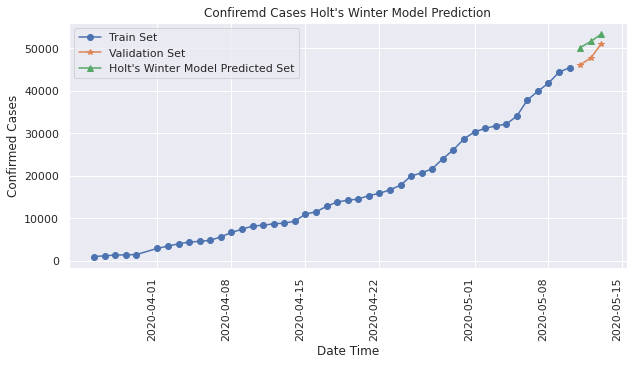

In [0]:
plt.figure(figsize=(10,5))
plt.plot(model_train.Confirmed,label="Train Set",marker='o')
valid.Confirmed.plot(label="Validation Set",marker='*')
y_pred["Holt\'s Winter Model"].plot(label="Holt's Winter Model Predicted Set",marker='^')
plt.ylabel("Confirmed Cases")
plt.xlabel("Date Time")
plt.title("Confiremd Cases Holt's Winter Model Prediction")
plt.xticks(rotation=90)
plt.legend()

In [0]:
#Comparing all the algorithms

holt_winter_new_prediction=[]
for i in range(1,18):
    holt_winter_new_prediction.append(es.forecast((len(valid)+i))[-1])
model_predictions["Holt's Winter Model Prediction"]=holt_winter_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction
0,2020-05-14,41433.180470,56177.845113,79126.277274,49664.631754,55585.251407
1,2020-05-15,42382.486957,58929.945042,86641.544285,51241.249647,60340.556165
2,2020-05-16,43331.793443,61780.777296,94782.692428,52817.867541,65188.328589
3,2020-05-17,44281.099929,64732.147412,103588.025478,54394.485434,67047.485387
4,2020-05-18,45230.406415,67785.845605,113097.379062,55971.103327,69336.998759


In [0]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [0]:
#Applying facebook prophet 

prophet_c=Prophet(interval_width=0.95,weekly_seasonality=True,)
prophet_confirmed=pd.DataFrame(zip(list(datewise.index),list(datewise["Confirmed"])),columns=['ds','y'])

prophet_c.fit(prophet_confirmed)

forecast_c=prophet_c.make_future_dataframe(periods=30)
forecast_confirmed=forecast_c.copy()

confirmed_forecast=prophet_c.predict(forecast_c)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
model_scores.append(np.sqrt(mean_squared_error(datewise["Confirmed"],confirmed_forecast['yhat'].head(datewise.shape[0]))))
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(datewise["Confirmed"],confirmed_forecast['yhat'].head(datewise.shape[0]))))

Root Mean Squared Error for Prophet Model:  417.46495652488824


Figure(720x432)


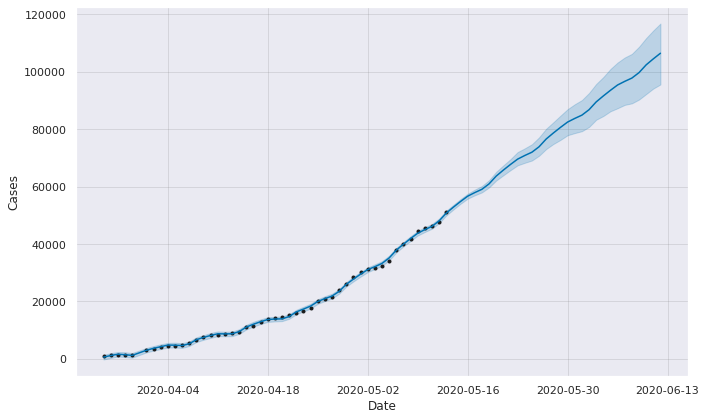

In [0]:
#Covid forecast Cases

print(prophet_c.plot(confirmed_forecast, xlabel='Date', ylabel='Cases'))

In [0]:
prophet_c=Prophet(interval_width=0.95,weekly_seasonality=True,)
prophet_deaths=pd.DataFrame(zip(list(datewise.index),list(datewise["Deaths"])),columns=['ds','y'])

In [0]:
prophet_c.fit(prophet_deaths)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
forecast_c=prophet_c.make_future_dataframe(periods=30)
forecast_deaths=forecast_c.copy()

In [0]:
deaths_forecast=prophet_c.predict(forecast_c)

In [0]:
model_scores.append(np.sqrt(mean_squared_error(datewise["Deaths"],deaths_forecast['yhat'].head(datewise.shape[0]))))
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(datewise["Deaths"],deaths_forecast['yhat'].head(datewise.shape[0]))))

Root Mean Squared Error for Prophet Model:  40.560124388599526


Figure(720x432)


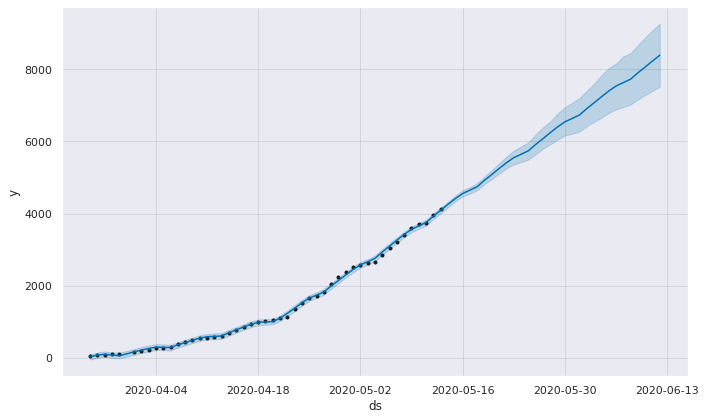

In [0]:
#Covid forecast deaths

print(prophet_c.plot(deaths_forecast))